<a href="https://colab.research.google.com/github/kconstable/market_predictions/blob/main/market_data_av.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
import sys
# !{sys.executable} -m pip install plotly

In [33]:
import pandas as pd
import numpy as np
import requests
import time
from datetime import date, timedelta,datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# alphavalue key
key = '2Y4KISB4XMRRRPW7'

## Cypto Currencies

In [27]:
def get_crypto_intraday(symbol,key,interval='60min',outputsize='compact',market='USD'):
  """
  CRYPTO_INTRADAY
    symbol: DOGE, BTC, ETH
    key: apikey
    interval: 1min, 5min, 15min, 30min, 60min
    outputsize: compact(last 100), full (all)
    market: USD
  """

  # build query string, get data as json and convert to a dict
  url = f"https://www.alphavantage.co/query?function=CRYPTO_INTRADAY&symbol={symbol}&market={market}&interval={interval}&outputsize={outputsize}&apikey={key}"
  r = requests.get(url)
  d = r.json()

  # extract data to df
  df=pd.DataFrame(d[f'Time Series Crypto ({interval})']).T
  df.columns = ['open','high','low','close','volume']
  df['symbol'] = d['Meta Data']['2. Digital Currency Code']
  df['name'] = d['Meta Data']['3. Digital Currency Name']

  return df

In [2]:
# def get_crypto_data(symbol,key):
#   """
#   'ETH', 'BTC', 'DOGE'
#   """
#   # build query string, get data as json and convert to a dict
#   url = f'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={symbol}&market=CAD&apikey={key}'
#   r = requests.get(url)
#   d = r.json()

#   # extract data to df
#   df=pd.DataFrame(d['Time Series (Digital Currency Daily)']).T

#   # remove columns not required
#   # returns the price in two currencies, just keep USD
#   cols = [c for c in df.columns if '(CAD)' not in c]
#   df=df.loc[:, cols]
#   df.columns = ['open','high','low','close','volume','marketcap']

#   # add the cyrpto name
#   df['name'] = d['Meta Data']['3. Digital Currency Name']

#   return df


## Stocks

In [3]:
def get_ticker_data(symbol,key,outputsize='compact'):
  """
  Returns daily data for a stock (symbol)
    outputsize: compact(last 100) or full (20 years)
    key: apikey
  """
  url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize={outputsize}&apikey={key}'
  r = requests.get(url)
  d = r.json()

  # extract data to a df
  df = pd.DataFrame(d['Time Series (Daily)']).T
  df.columns = ['open','high','low','close','volume']
  df['symbol'] = d['Meta Data']['2. Symbol']

  # change data types
  df.index = pd.to_datetime(df.index)

  # convert datatype to float
  for col in ['open','high','low','close','volume']:
    df[col] = df[col].astype('float')

  # Print Results
  missing = sum(df.close.isna())
  total = df.shape[0]
  print(f"Ticker:{symbol}")
  print("---"*10)
  print(f"=>Missing Data:{missing}")
  print(f"=>Total Data:{total}")
  print(f"=>Percent Missing:{round(missing/total*100,2)}%\n")

  return df

## Economic Indicators

In [50]:
def get_economic_indicators(funct,key,interval=None,maturity=None):
  """
  Returns Economic Indicator Data with missing values interpolated between dates
  Monthly Data:
    NONFARM_PAYROLL, INFLATION_EXPECTATION,CONSUMER_SENTIMENT
  Daily, Weekly, Monthly Data:  
    FEDERAL_FUNDS_RATE = interval (daily,weekly,monthly)
    TREASURY_YIELD = interval (daily, weekly, monthly), 
                     maturity (3month, 5year, 10year, and 30year)
  """
  
  # query strings
  # Monthly Data:
  if funct in ['NONFARM_PAYROLL','INFLATION_EXPECTATION','CONSUMER_SENTIMENT']:
    url = f'https://www.alphavantage.co/query?function={funct}&apikey={key}'

  # Daily, Weekly or Monthly Data:
  # Interest Rates
  if funct == 'FEDERAL_FUNDS_RATE':
    url = f'https://www.alphavantage.co/query?function={funct}&interval={interval}&apikey={key}'

  # Treasury Yield  
  if funct == 'TREASURY_YIELD':
    url = f'https://www.alphavantage.co/query?function={funct}&interval={interval}&maturity={maturity}&apikey={key}'

  # pull data
  r = requests.get(url)
  time.sleep(2)
  d = r.json()

  # convert to df
  df = pd.DataFrame(d['data'])

  # move date to a datetime index
  df.date = pd.to_datetime(df.date)
  df.set_index('date',inplace=True)

  # add the ticker name and frequency
  df['name'] = d['name']
  df['interval']=d['interval'] 

  # clean data & interpolate missing values
  # missing data encoded with '.'
  # change datatype to float
  df.replace('.',np.nan,inplace=True)
  df.value = df.value.astype('float')

  # missing data stats
  missing =sum(df.value.isna())
  total =df.shape[0]

  # interpolate using the time index
  df.value.interpolate(method='time',inplace=True)

  # Print Status
  print(f"{funct}:")
  print("----"*10)
  print(f"=>Missing Values:{missing}")
  print(f"=>Total Values:{total}")
  print(f"=>Percent Interpolated:{round(missing/total*100,2)}%\n")

  return df



## Technical Indicators

In [5]:
def get_technical_indicators(symbol,funct,interval,key,time_period=None):
  """
  Returns Technical Indicators (only works for stocks, not cyrpto)
  MACD:   symbol,interval
  RSI:    symbol,interval,time_period
  BBANDS: symbol,interval,time_period

  Parameters:
          interval: (1min, 5min, 15min, 30min, 60min, daily, weekly, monthly)
          series_type: (open, close,high,low)
          timer_periods: Integer
  """
  # build the query string
  if funct =='MACD':
    url = f'https://www.alphavantage.co/query?function={funct}&symbol={symbol}&interval={interval}&series_type=close&apikey={key}'
  if funct in ['RSI','BBANDS']:
    url = f'https://www.alphavantage.co/query?function={funct}&symbol={symbol}&interval={interval}&series_type=close&time_period={time_period}&apikey={key}'

  # request data as json, convert to dict
  r = requests.get(url)
  d = r.json()

  # extract to a df and add the symbol
  df = pd.DataFrame(d[f'Technical Analysis: {funct}']).T
  df['symbol'] = symbol

  return df


In [25]:
def plot_candlestick(df):
    """
    
    """
    # get ticker name
    name = df.symbol.unique()[0]
    
    # Create subplots
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                        subplot_titles=('Prices: Open/High/Low/Close', 'Volume'),
                        vertical_spacing=0.07)
                   
    # OHLC Plot
    fig.add_trace(go.Candlestick(x=df.index, open=df.open, high=df.high,low=df.low, close=df.close, 
                name="Price",
                increasing_line_color= 'rgba(26,150,65,1)', 
                decreasing_line_color= 'lightcoral'), 
                row=1, col=1)
    
    # area chart for volume
    fig.add_trace(go.Scatter(x=df.index, y=df.volume, 
                fill='tozeroy',
                name='Volume',
                mode='none',
                fillcolor='rgba(26,150,65,0.5)'),
                row=2,col=1)

    # Do not show OHLC's rangeslider plot 
    fig.update(layout_xaxis_rangeslider_visible=False)
    fig.update_layout(template='plotly_white',
                      title = f"Candlestick and Volume Chart: {name}")
          
    fig.show()
    

In [17]:
df = get_ticker_data('BLX',key,outputsize='full')
plot_candlestick(df)

In [26]:
# df = get_crypto_data('ETH',key)
plot_candlestick(df)

## Combine Stock Data
+ price data
+ economic
+ technical

In [177]:
# combine stock data

# daily stock prices
# blx  = get_ticker_data('BLX',key)

# daily economic indicators
# t10y = get_economic_indicators('TREASURY_YIELD',key,interval='daily',maturity='10year')
# t5y  = get_economic_indicators('TREASURY_YIELD',key,interval='daily',maturity='5year')
# ir   = get_economic_indicators('FEDERAL_FUNDS_RATE',key,interval='daily')

# # monthly economic indicators
nfp  = get_economic_indicators('NONFARM_PAYROLL',key)
infl = get_economic_indicators('INFLATION_EXPECTATION',key)
cs   = get_economic_indicators('CONSUMER_SENTIMENT',key)


# # daily technical
# rsi  = get_technical_indicators('BLX','RSI','daily',key,time_period=60)
# bb   = get_technical_indicators('BLX','BBANDS','daily',key,time_period=10)
# macd = get_technical_indicators('BLX','MACD','daily',key,time_period=60)

NONFARM_PAYROLL:
------------------------------
=>Missing Values:0
=>Total Values:991
=>Percent Interpolated:0.0%

INFLATION_EXPECTATION:
------------------------------
=>Missing Values:0
=>Total Values:522
=>Percent Interpolated:0.0%

CONSUMER_SENTIMENT:
------------------------------
=>Missing Values:210
=>Total Values:824
=>Percent Interpolated:25.49%



In [188]:
cs.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 824 entries, 2021-06-01 to 1952-11-01
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   value     824 non-null    float64
 1   name      824 non-null    object 
 2   interval  824 non-null    object 
dtypes: float64(1), object(2)
memory usage: 25.8+ KB


In [32]:
config = {'TREASURY_YIELD':[{'interval':'daily','maturity':'10year','name':'yield10y'},
                            {'interval':'daily','maturity':'5year','name':'yield5y'}],
          'FEDERAL_FUNDS_RATE':{'interval':'daily','name':'ir'},
          'NONFARM_PAYROLL':{'interval':'monthly','name':'nfp'},
          'CONSUMER_SENTIMENT':{'interval':'monthly','name':'cs'},
          'INFLATION_EXPECTATION':{'interval':'monthly','name':'infl'}
          }

config   

{'CONSUMER_SENTIMENT': {'interval': 'monthly', 'name': 'cs'},
 'FEDERAL_FUNDS_RATE': {'interval': 'daily', 'name': 'ir'},
 'INFLATION_EXPECTATION': {'interval': 'monthly', 'name': 'infl'},
 'NONFARM_PAYROLL': {'interval': 'monthly', 'name': 'nfp'},
 'TREASURY_YIELD': [{'interval': 'daily',
   'maturity': '10year',
   'name': 'yield10y'},
  {'interval': 'daily', 'maturity': '5year', 'name': 'yield5y'}]}

In [52]:
def get_consolidated_stock_data(symbol,key,config):
  """
  """

  # daily stock prices
  dff  = get_ticker_data(symbol,key)

  # loop through the config to pull the requested data
  for indicator,values in config.items():
    if indicator == 'TREASURY_YIELD':
      for tr in values:
        try:
          df = get_economic_indicators(indicator,key,interval=tr['interval'],maturity=tr['maturity'])
          dff = dff.join(df,how='left')
          dff.rename(columns={"value": tr['name']},inplace=True)
          dff.drop(['name', 'interval'], axis=1,inplace = True)
        except:
          print(f"Error===>{indicator}:{tr['maturity']}")
   
    else: 
      # daily
      if values['interval']=='daily':
        try:
          df = get_economic_indicators(indicator,key,interval=values['interval'])
          dff = dff.join(df,how='left')
          dff.rename(columns={"value": values['name']},inplace=True)
          dff.drop(['name', 'interval'], axis=1,inplace = True)
        except:
          print(f"Error===>{indicator}")
  
      else: 
        try:
          # monthly or weekly
          df = get_economic_indicators(indicator,key)

          # reindex to daily, fill missing values forward
          days = pd.date_range(start = min(df.index),end =max(df.index),freq='D')
          df =df.reindex(days,method = 'ffill')
      
          # join with the other data
          dff = dff.join(df,how='left')
          dff.rename(columns={"value": values['name']},inplace=True)
          dff.drop(['name', 'interval'], axis=1,inplace = True)
        except:
          print(f"Error===>{indicator}")


  # Fill in any missing data after joining all datasets
  dff.fillna(method='bfill',inplace=True,axis = 0)

  # # daily technical
  # rsi  = get_technical_indicators('BLX','RSI','daily',key,time_period=60)
  # bb   = get_technical_indicators('BLX','BBANDS','daily',key,time_period=10)
  # macd = get_technical_indicators('BLX','MACD','daily',key,time_period=60)


  return dff



dff = get_consolidated_stock_data('BLX',key,config)
dff

Ticker:BLX
------------------------------
=>Missing Data:0
=>Total Data:100
=>Percent Missing:0.0%

TREASURY_YIELD:
----------------------------------------
=>Missing Values:663
=>Total Values:15562
=>Percent Interpolated:4.26%

TREASURY_YIELD:
----------------------------------------
=>Missing Values:663
=>Total Values:15562
=>Percent Interpolated:4.26%

FEDERAL_FUNDS_RATE:
----------------------------------------
=>Missing Values:0
=>Total Values:24528
=>Percent Interpolated:0.0%

NONFARM_PAYROLL:
----------------------------------------
=>Missing Values:0
=>Total Values:991
=>Percent Interpolated:0.0%

CONSUMER_SENTIMENT:
----------------------------------------
=>Missing Values:210
=>Total Values:824
=>Percent Interpolated:25.49%

INFLATION_EXPECTATION:
----------------------------------------
=>Missing Values:0
=>Total Values:522
=>Percent Interpolated:0.0%



,open,high,low,close,volume,symbol,yield10y,yield5y,ir,nfp,cs,infl
2021-08-26,16.59,16.88,16.4820,16.60,146182.0,BLX,1.35,0.84,0.09,146470.0,85.5,4.2
2021-08-25,16.43,16.90,16.3600,16.59,203361.0,BLX,1.35,0.84,0.09,146470.0,85.5,4.2
2021-08-24,16.61,16.62,16.4300,16.49,75493.0,BLX,1.29,0.80,0.09,146470.0,85.5,4.2
2021-08-23,16.54,16.72,16.4000,16.59,122812.0,BLX,1.25,0.78,0.09,146470.0,85.5,4.2
2021-08-20,16.32,16.63,16.2836,16.47,124525.0,BLX,1.26,0.80,0.09,146470.0,85.5,4.2
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-13,14.80,14.95,14.7200,14.74,90790.0,BLX,1.64,0.85,0.07,145355.0,82.9,4.6
2021-04-12,14.83,15.08,14.8300,14.87,44551.0,BLX,1.69,0.89,0.07,145355.0,82.9,4.6
2021-04-09,14.98,15.03,14.8250,14.87,99315.0,BLX,1.67,0.87,0.07,145355.0,82.9,4.6
2021-04-08,15.09,15.15,14.8800,14.98,131217.0,BLX,1.64,0.85,0.07,145355.0,82.9,4.6


In [53]:
dff.describe()

,open,high,low,close,volume,yield10y,yield5y,ir,nfp,cs,infl
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000
mean,15.509550,15.684046,15.360933,15.521700,99242.040000,1.470300,0.808200,0.080200,146297.230000,85.03200,4.272000
std,0.652431,0.684924,0.653029,0.670162,48342.929992,0.154026,0.059295,0.018367,446.813315,1.00392,0.154449
min,14.330000,14.600000,14.300000,14.400000,44551.000000,1.190000,0.650000,0.050000,145355.000000,82.90000,4.200000
25%,15.077500,15.227875,14.945000,15.085000,72063.250000,1.310000,0.780000,0.060000,146470.000000,85.50000,4.200000
50%,15.295000,15.465050,15.170000,15.310000,84687.500000,1.500000,0.810000,0.070000,146470.000000,85.50000,4.200000
75%,15.777500,16.127500,15.647500,15.875000,113159.750000,1.610000,0.850000,0.100000,146470.000000,85.50000,4.200000
max,17.000000,17.210000,16.800000,16.980000,363712.000000,1.690000,0.920000,0.100000,146603.000000,85.50000,4.600000


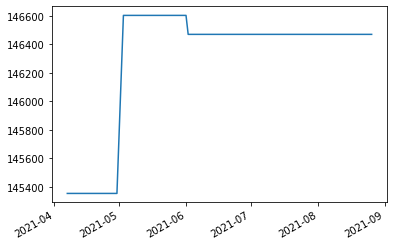

In [54]:
dff.nfp.plot()

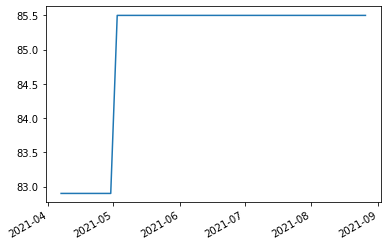

In [55]:
dff.cs.plot()

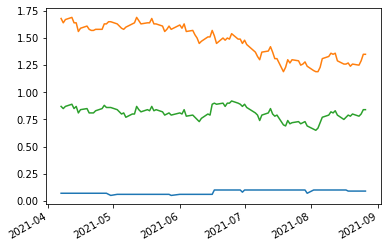

In [56]:
dff.ir.plot()
dff.yield10y.plot()
dff.yield5y.plot()